In [62]:
!mkdir -p ../data/quickdraw-doodle
!kaggle competitions download -c quickdraw-doodle-recognition -f train_simplified/apple.csv -p ../data/quickdraw-doodle
!unzip -o ../data/quickdraw-doodle/apple.csv.zip -d ../data/quickdraw-doodle
!rm ../data/quickdraw-doodle/apple.csv.zip

 98%|█████████████████████████████████████▏| 19.0M/19.4M [00:02<00:00, 8.24MB/s]
100%|██████████████████████████████████████| 19.4M/19.4M [00:02<00:00, 8.00MB/s]
Archive:  ../data/quickdraw-doodle/apple.csv.zip
  inflating: ../data/quickdraw-doodle/apple.csv  


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import ast # ast.literal_eval 문자열에 담겨있는 표현식 제한된 literal로 구성된 표현식만 허용.
import numpy as np

In [5]:
# https://www.kaggle.com/code/gaahan/diffusion

size = 128
BASE_SIZE = 256

## Return img array from cv2
def draw_cv2(raw_strokes, size=256, lw=6):
    img = np.zeros((BASE_SIZE, BASE_SIZE), np.uint8)
    for stroke in raw_strokes:
        for i in range(len(stroke[0]) - 1):
            _ = cv2.line(img, (int(stroke[0][i]), int(stroke[1][i])), (int(stroke[0][i + 1]), int(stroke[1][i + 1])), 255, lw)
    if size != BASE_SIZE:
        return cv2.resize(img, (size, size))
    else:
        return img

## Take df (pandas Dataframe) and convert to image with pixel value between 0 and 1   
def df_to_image_array(df, size=size, lw=6):
    df['drawing'] = df['drawing'].apply(ast.literal_eval)
    x = np.zeros((len(df), size, size))
    for i, raw_strokes in enumerate(df.drawing.values):
        x[i] = draw_cv2(raw_strokes, size=size, lw=lw)
    x = x / 255.
    x = x.reshape((len(df), 1, size, size)).astype(np.float32)
    return x

In [6]:
raw_df = pd.read_csv('../data/quickdraw-doodle/apple.csv')

In [7]:
valid_df = df_to_image_array(raw_df)

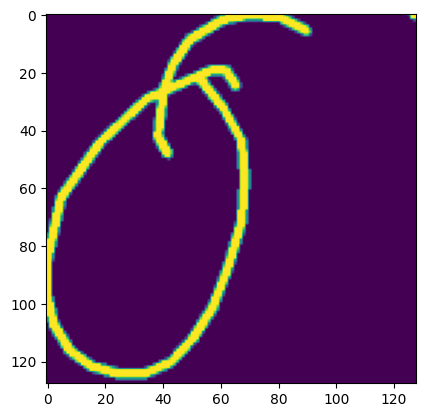

In [9]:
plt.imshow(valid_df[0, 0, :, :]*255)

In [6]:
valid_df.shape

(144722, 1, 128, 128)

In [8]:
!pip install torchvision torch

^C


In [7]:
from torchvision import datasets




ModuleNotFoundError: No module named 'torchvision'

In [ ]:
torch.utils.data.DataLoader

## pytorch

In [ ]:
"""

Make GAN
https://github.com/eriklindernoren/PyTorch-GAN/tree/master/implementations
"""

from torchvision import datasets
import torchvision.transforms as transforms

import numpy as np
import os
import torch
import matplotlib.pyplot as plt


class GAN(torch.nn.Module):

    def __init__(self, noise=100, image_shape=(1, 28, 28)):
        super().__init__()

        GAN.noise = noise
        GAN.image_shape = image_shape

        # setting enviroment.
        GAN.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        if GAN.device.type == 'cuda':
            print(f'"Cuda" is Available')
        else:
            print(f'"CPU" is Available.')

        model_gen = self.initialize_weights(GAN.Generator().to(GAN.device))
        model_dis = self.initialize_weights(GAN.Discriminator().to(GAN.device))
        dataloader = self.MNIST()

        # train
        generator, discriminator, history = self.train(model_gen, model_dis, dataloader)

        self.plot_loss_history(
            history['gen'],history['dis'],
            label1='Gen Loss', label2='Dis Loss', 
            figsize=(16,8), image_name='Pytorch_GAN',
        )

        # torch.save(generator.state_dict(), 'pytorch_weights_gen.pt')
        # torch.save(discriminator.state_dict(), 'pytorch_weights_dis.pt')


    class Generator(torch.nn.Module):
        def __init__(self):
            super(GAN.Generator, self).__init__()

            self.model = torch.nn.Sequential(
                self.FullyConnectNet(GAN.noise, 128, normalize=True),
                self.FullyConnectNet(128, 256),
                self.FullyConnectNet(256, 512),
                torch.nn.Linear(512, int(torch.prod(torch.tensor(GAN.image_shape)))),
                torch.nn.Tanh()
            )

        def forward(self, noise):
            image = self.model(noise)
            image = image.view(image.size(0), *GAN.image_shape)
            return image
        
        def FullyConnectNet(self, input_size, output_size, normalize=True):
            layers = []
            layers.append(torch.nn.Linear(input_size, output_size))
            if normalize:
                layers.append(torch.nn.BatchNorm1d(output_size, .8))
            layers.append(torch.nn.LeakyReLU(.2)) # 이미지는 음수값이 없으므로

            return torch.nn.Sequential(*layers)


    class Discriminator(torch.nn.Module):
        def __init__(self):
            super(GAN.Discriminator, self).__init__()

            self.model = torch.nn.Sequential(
                torch.nn.Linear(int(torch.prod(torch.tensor(GAN.image_shape))), 512),
                torch.nn.LeakyReLU(.2, inplace=True),
                torch.nn.Linear(512, 256),
                torch.nn.LeakyReLU(.2, inplace=True),
                torch.nn.Linear(256, 1),
                torch.nn.Sigmoid()
            )

        def forward(self, image):
            image_flat = image.view(image.size(0), -1).to(GAN.device)
            validity = self.model(image_flat)
            return validity


    def initialize_weights(self, model):
        for m in model.modules():
            if isinstance(m, torch.nn.Linear):
                torch.nn.init.normal_(m.weight, 0, 0.01)
                torch.nn.init.constant_(m.bias, 0)
            elif isinstance(m, torch.nn.BatchNorm1d):
                torch.nn.init.normal_(m.weight, 1.0, 0.02)
                torch.nn.init.constant_(m.bias, 0)
        
        return model

    def MNIST(self, image_size=28, batch_size=64):
        os.makedirs('../data/mnist', exist_ok=True)
        dataloader = torch.utils.data.DataLoader(
                datasets.MNIST(
                '../data/mnist',
                train=True,
                download=True,
                transform=transforms.Compose(
                    [transforms.Resize(image_size), 
                    transforms.ToTensor(), 
                    transforms.Normalize([.5],[.5])]
                )
            ),
            batch_size=batch_size,
            shuffle=True,
        )
        return dataloader

    def plot_loss_history(
            self, loss1, loss2, label1='label 1', label2='label 2', 
            figsize=(16,8), title='Title', xlabel='Batch', ylabel='Loss', image_name='temp'
            ):
        
        plt.figure(figsize=figsize)
        plt.title(title)
        plt.plot(np.arange(len(loss1)),loss1, label=label1)
        plt.plot(np.arange(len(loss1)),loss2, label=label2)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.legend()
        plt.savefig(f'{image_name}.png')

    def train(self, generator, discriminator, dataloader, num_epochs=2, noise=100, lr=2e-4, b1=0.5, b2=.999):

        loss_history = {'gen':[], 'dis':[]}

        # Initialize binary cross-entropy loss and optimizers
        adversarial_loss = torch.nn.BCELoss()
        optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
        optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

        # Train the GAN for the specified number of epochs
        for epoch in range(num_epochs):
            for i, (imgs, _) in enumerate(dataloader):
                batch_size = imgs.shape[0]

                valid_labels = torch.ones(batch_size, 1).to(GAN.device)
                fake_labels = torch.zeros(batch_size, 1).to(GAN.device)

                # =======================
                # Train the generator
                # =======================

                # Generate fake images from random noise
                z = torch.randn(batch_size, noise, device=GAN.device)
                gen_imgs = generator(z)

                g_loss = adversarial_loss(discriminator(gen_imgs), valid_labels)

                optimizer_G.zero_grad()
                g_loss.backward()
                optimizer_G.step()

                # =======================
                # Train the discriminator
                # =======================
                real_loss = adversarial_loss(discriminator(imgs), valid_labels)
                fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake_labels)

                d_loss = (real_loss + fake_loss) / 2

                optimizer_D.zero_grad() # zero_grad가 없으면 이전 값이 다음 학습에 영향을 미침.
                d_loss.backward()
                optimizer_D.step()

    
                loss_history['gen'].append(g_loss.item())
                loss_history['dis'].append(d_loss.item())

                # Print the progress
                if i % 10 == 0:
                    print(
                        "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]" 
                        % (epoch, num_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
                    )

        return generator, discriminator, loss_history

        
if __name__ == '__main__':
    GAN()

## tensorflow

In [ ]:

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras import optimizers


import numpy as np
import os
import matplotlib.pyplot as plt


class GAN(tf.keras.Model):

    def __init__(self, noise=100, image_shape=(1, 28, 28)):
        super().__init__()

        self.noise_dim = noise
        self.image_shape = image_shape
        self.BATCH_SIZE = 256

        # setting enviroment.
        self.device = tf.device('cuda' if tf.config.list_physical_devices('GPU') else 'cpu')
        if self.device.type == 'cuda':
            print(f'"GPU" is Available')
        else:
            print(f'"CPU" is Available.')

        self.generator = self.Generator()
        self.discriminator = self.Discriminator()

        optimizer_G = optimizers.Adam(2e-4)
        optimizer_D = optimizers.Adam(2e-4)



        # torch.save(generator.state_dict(), 'pytorch_weights_gen.pt')
        # torch.save(discriminator.state_dict(), 'pytorch_weights_dis.pt')

    def dense_block(self, units, input_dim=None, normalize=False, momentum=0.8, alpha=0.2):
        block = Sequential()
        block.add(layers.Dense(units, input_dim=input_dim))

        if normalize:
            block.add(layers.BatchNormalization(momentum=momentum))

        block.add(layers.LeakyReLU(alpha=alpha))
        
        return block

    def Generator(self, noise):
        
        model = Sequential(
            [self.dense_block(128, normalize=True, input_dim=noise),
             self.dense_block(256, normalize=True),
             self.dense_block(512, normalize=True),
             layers.Dense(tf.reduce_prod(noise), activation='tanh'),
             layers.Reshape(self.image_shape)
             ]
        )

        return model

    def Discriminator(self):
        model = Sequential(
            [layers.Flatten(input_shape=self.image_shape),
             self.dense_block(512),
             self.dense_block(256),numpy imageca
             layers.Dense(1, activation='sigmoid')
             ]
        )
        return model

    def cross_entropy(self):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True)
    
    def discriminator_loss(self, real_output, fake_output):
        real_loss = self.cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss
    
    def generator_loss(self, fake_output):
        return self.cross_entropy(tf.ones_like(fake_output), fake_output)

    @tf.function
    def train_step(self, images):
        noise = tf.random.normal([self.BATCH_SIZE, self.noise_dim])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(noise, training=True)

        real_output = self.discriminator(images, training=True)
        fake_output = self.discriminator(generated_images, training=True)

        gen_loss = self.generator_loss(fake_output)
        disc_loss = self.discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.optimizer_G.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.optimizer_D.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))


    def train(self, dataset, num_epochs):
        for epoch in range(num_epochs):
            for i, img in enumerate(dataset):
                self.train_step(img)

if __name__ == '__main__':
    
    # https://www.kaggle.com/competitions/quickdraw-doodle-recognition/data